# Title

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?". **This question was chosen because....**

## 1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

In [5]:
df = pd.read_csv("data/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Feature selection

Explore the data to find the count of observations and distribution of values for each variable.

In [3]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the number of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Since this analysis aims to explore the effect of other variables on the number of reviews, it will not be necessary to retain 'reviews_per_month' or 'last_review'. These will be strongly correlated with number of reviews but only because they are measures of the number of reviews.

In [6]:
# for now:

df = df.drop(columns = ['name','id', 'host_id', 'host_name', 'last_review','reviews_per_month'])
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


### Handling missing values

In [7]:
# examine missing values

df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

There are no observations with missing values.

### Target variable

The target variable is the number of reviews expressed as either 1 (meaning the listing has reviews) or 0 (meaning the listing does not have reviews).

In [9]:
df['has_reviews'] = df['number_of_reviews'].apply(lambda r: 0 if r == 0 else 1)
# can now drop the number of reviews as it is no longer needed.
df.drop(columns = ['number_of_reviews'], inplace = True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,6,365,1
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,2,355,1
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,1,365,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,1,194,1
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,1,0,1


### EDA
Before finding out what factors influence whether or not there are reviews for a listing, we should explore and visualise the data a little further.

We will start by plotting the number of observations of each class (1 for has reviews, 0 for has no reviews).

1    38843
0    10052
Name: has_reviews, dtype: int64


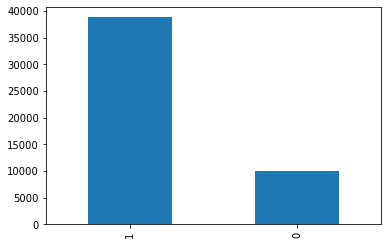

In [15]:
count_reviews = df['has_reviews'].value_counts()
print(count_reviews)
count_reviews.plot(kind = 'bar');

Next, examine the distribution of numeric features, starting with price.

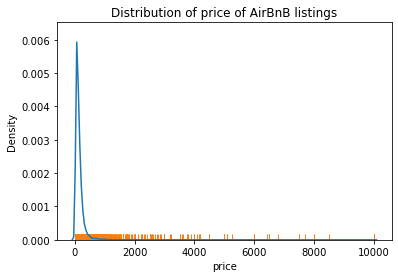

In [17]:
# Now examine distributions of numeric features, e.g. price

sns.kdeplot(data = df, # ignore the outliers for visualisation
            x = 'price')
sns.rugplot(data = df, # ignore the outliers for visualisation
            x = 'price')
plt.title("Distribution of price of AirBnB listings");

Some of these prices are extremely high, which makes it difficult to ascertain the shape of the distribution at the lower range. For the purposes of the visualisation only, the prices above $2000 will be omitted.

Next, the distribution of availability values will be examined.

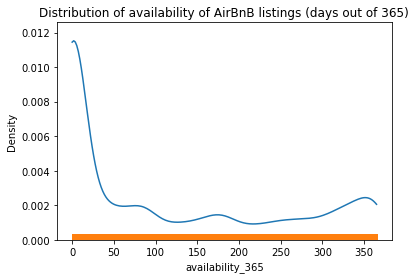

In [20]:
df_vis = df[df['price']<=2000]

sns.kdeplot(data = df_vis, x = 'availability_365', clip = (0,365))
sns.rugplot(data = df_vis, x = 'availability_365')

plt.title("Distribution of availability of AirBnB listings (days out of 365)");

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely.

In [29]:
df[df['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

,availability_365
has_reviews,
0,4845
1,12688


So many of the listings that are unavailable still have reviews.

In [ ]:
sns.kdeplot(data = df_vis, x = 'calculated_host_listings_count', clip = (0, 500))
sns.rugplot(data = df_vis, x = 'calculated_host_listings_count')
plt.title("Distrinbution of host listings count");

In [ ]:
df[df['calculated_host_listings_count']>150].groupby('calculated_host_listings_count')['name'].count()

There are two hosts with very large numbers of listings (232 and 327). Temporarily omit any properties of hosts that have > 40 properties just to observe the spread.

In [ ]:
df_vis = df_vis[df_vis['calculated_host_listings_count']<=40]
sns.kdeplot(data = df_vis,x = 'calculated_host_listings_count')
sns.rugplot(data = df_vis,x = 'calculated_host_listings_count')
plt.title("Distrinbution of host listings count");

Given how few listings belong to hosts with more than one listing, it might make more sense to replace with listing with a 0/1 option (1 or more listings). I will add this feature now to consider later.

In [ ]:
df['multiple_host_listings'] = df['calculated_host_listings_count'].apply(lambda count: 1 if count > 1 else 0)
df['multiple_host_listings'].value_counts()

In [ ]:
corr = df.corr()

ax = sns.heatmap(corr, 
                 vmin = -1, vmax = 1, center = 0,
                 cmap = sns.color_palette("vlag"))

There is almost no correlation between the numerical features. Next we will consider the neighbourhoods and their effect on the distribution of monthly reviews.

In [ ]:
sns.scatterplot(data = df_vis, x = 'price', y = 'reviews_per_month', hue = 'neighbourhood_group', alpha = 0.5);

In [ ]:
sns.scatterplot(data = df_vis, x = 'price', y = 'reviews_per_month', hue = 'room_type', alpha = 0.5);

In [ ]:
sns.scatterplot(x = 'minimum_nights', y = 'reviews_per_month', data = df_vis);

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.scatterplot(data=df_vis, x = 'calculated_host_listings_count', y = 'reviews_per_month');

In [ ]:
sns.kdeplot(data = df[df['reviews_per_month']<20], x = 'reviews_per_month', hue = 'neighbourhood_group', alpha = 0.8);

## Feature engineering

In [ ]:
neighbourhood_groups = pd.get_dummies(df['neighbourhood_group'])
df[neighbourhood_groups.columns] = neighbourhood_groups
#df.drop(columns= ['neighbourhood_group'], inplace = True)
df.head()

In [ ]:
room_types = pd.get_dummies(df['room_type'])
df[room_types.columns] = room_types
#df.drop(columns = ['room_type'], inplace = True)
df.head()

In [ ]:
# we actually don't need all of the neighbourhood groups and all of the room types - 
#     - if an observation is not entire home/apt and is not private room then we can infer it is a shared room

df.drop(columns = ['Staten Island', 'Shared room'], inplace = True)

In [ ]:
df.columns

## Converting number of monthly reviews to boolean value

Given the shape of the distribution of reviews per month (above), it seems more sensible to attempt to classify listings as "listings with reviews" and "listings without reviews".

In [ ]:
# we introduce a 'has_reviews' column to show whether or not there *are* any reviews.
df['has_reviews'] = df['reviews_per_month'].apply(lambda count: 0 if count == 0 else 1)
df.head()

In [ ]:
sns.scatterplot(data = df, x = 'price', hue = 'neighbourhood_group', y = 'has_reviews', alpha = 0.8);

In [ ]:
sns.scatterplot(data = df, x = 'calculated_host_listings_count', hue = 'room_type', y = 'has_reviews', alpha = 0.8);

In [ ]:
# we're going to work with a smaller number of these columns

airbnb_features = df.drop(columns = ['name','neighbourhood_group', 'room_type', 'neighbourhood', 'number_of_reviews', 'calculated_host_listings_count'])
airbnb_features.head()

As demonstrated in the visualisations above, price, reviews_per_month, availability_365 are not normally distributed. They are all also on vastly different scales, so they should be normalised. Because there are outliers in all of these features, a `RobustScaler()` should be used rather than a min-max scaler.

In [ ]:
from sklearn.preprocessing import RobustScaler

# create robust scaler object
scaler = RobustScaler()

# fit and transform the data with the robust scaler
airbnb_scaled = pd.DataFrame(scaler.fit_transform(X = airbnb_features), columns = airbnb_features.columns)
airbnb_scaled.head()

In [ ]:
airbnb_scaled['has_reviews'].value_counts()

The robust scaler has shifted the variables with 0 or 1 values so that 0 becomes -1 and 1 becomes 0.

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(ncols = 3, nrows = 2, figsize = (15, 10), sharey = False)

for col, ax in zip(airbnb_scaled.columns.tolist()[:6], [ax1, ax2, ax3, ax4, ax5, ax6]):
    airbnb_scaled[col].plot.density(ax = ax, title = col)

In [ ]:
# convert our target variable to integer

airbnb_scaled['has_reviews'] = airbnb_scaled['has_reviews'].astype('int')

## What factors influence whether or not a listing has received reviews?


In [ ]:
X = airbnb_scaled.drop(columns = ['reviews_per_month', 'has_reviews']).values
X[:2]

In [ ]:
y = airbnb_scaled['has_reviews'].values
y[:10]

### Split the data into training and test datasets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4, stratify = y)
X_test[:4]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
type(y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
from typing import List

def plot_confusion_matrix(labels: List[int], tick_labels: List[str], y_test: np.ndarray, y_pred: np.ndarray, normalise = True):
    labels = [-1, 0]
    tick_labels = ["No reviews", "Reviews"]
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
    print(conf_matrix)
    # Plotting the confusion matrix with color scale.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_matrix, cmap="coolwarm")
    fig.colorbar(cax)
    ax.set_xticklabels([''] + tick_labels)
    ax.set_yticklabels([''] + tick_labels)
    plt.xlabel('Predicted')
    ax.xaxis.set_label_position('top') 
    plt.ylabel('True');
    
plot_confusion_matrix(labels = [-1.0,0.0], tick_labels = ['No reviews', 'reviews'], y_test=y_test, y_pred=y_pred)

In [ ]:
from sklearn.metrics import classification_report
classif_report = classification_report(y_test, y_pred, target_names=tick_labels)
print(classif_report)

In [ ]:
from sklearn.metrics import f1_score

preds = []

for k in list(range(1,21)):
    neigh_test = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    y_pred = neigh_test.predict(X_test)
    preds.append(f1_score(y_test, y_pred, pos_label = 0))
    
sns.lineplot(x = range(1,21), y = preds)

In [ ]:
k = 12
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred[:5]

In [ ]:
from sklearn.metrics import confusion_matrix

labels = [-1.0, 0.0]
tick_labels = ["No reviews", "Reviews"]

plot_confusion_matrix(labels, tick_labels, y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, target_names=tick_labels))

In [ ]:
from sklearn.linear_model import LogisticRegression

regr = LogisticRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

f1_score(y_test, y_pred, pos_label = 0)

In [ ]:
plot_confusion_matrix(labels, tick_labels, y_test, y_pred)

In [ ]:
## hyperparameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 0.4, 0.6, 0.8, 1.0],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    }
     

regr = LogisticRegression()

regr_best = GridSearchCV(regr, param_grid, cv=5,
                                  scoring="f1",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

regr_best.fit(X_train, y_train.reshape(-1, 1))
y_pred = regr_best.predict(y_test)

In [ ]:
LogisticRegression().get_params().keys()

## notes to self

Try:
- SVM
- decision tree classifier
- feature trimming.
